In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, roc_auc_score, roc_curve
from sklearn.preprocessing import LabelEncoder, label_binarize
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, Callback
from itertools import cycle
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from collections import Counter
import shutil

In [2]:
# Paths
train_dir = r"C:\Users\guitar123\Desktop\Senior Project\dataset\HAM10000\train"
val_dir = r"C:\Users\guitar123\Desktop\Senior project\dataset\HAM10000\val"
test_dir = r"C:\Users\guitar123\Desktop\Senior project\dataset\HAM10000\test"

# Constants
IMAGE_HEIGHT = 600
IMAGE_WIDTH = 450
SIZE = (IMAGE_HEIGHT, IMAGE_WIDTH)
IMAGE_CHANNELS = 3  # Assuming RGB images
BATCH_SIZE = 16
EPOCHS = 1000
NUM_CLASSES = len(os.listdir(train_dir))

In [3]:
# Resample function to balance each class to 500 samples
def resample_data(directory, target_count=500):
    class_dirs = [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))]
    for class_dir in class_dirs:
        class_path = os.path.join(directory, class_dir)
        images = glob(os.path.join(class_path, "*.jpg"))
        current_count = len(images)
        if current_count < target_count:
            # Augment the class to have `target_count` images
            for i in range(target_count - current_count):
                image = images[i % current_count]
                image_name = os.path.basename(image)
                new_image_name = f"aug_{i}_{image_name}"
                new_image_path = os.path.join(class_path, new_image_name)
                shutil.copy(image, new_image_path)
        elif current_count > target_count:
            # Reduce the class to `target_count` images
            for image in images[target_count:]:
                os.remove(image)
                

In [4]:
## Resample training data
resample_data(train_dir)


# Create ImageDataGenerator instances
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Generate data from directories
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


Found 3500 images belonging to 7 classes.
Found 2005 images belonging to 7 classes.
Found 1515 images belonging to 7 classes.


In [5]:
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
import os

# Load the VGG16 model without the top fully connected layers (include_top=False)
base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS))

# Freeze the base_model layers to prevent them from being trained
for layer in base_model.layers[-30:]:
    layer.trainable = False
    
## Unfreeze the top layers for fine-tuning
#for layer in base_model.layers[-30:]:
#    layer.trainable = True

# Add custom layers on top of the base model with L2 regularization
x = base_model.output
#x = Dropout(0.3)(x)
x = GlobalAveragePooling2D()(x)

# Add Dense layers with L2 regularization
x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
#x = Dropout(0.3)(x)
x = Flatten()(x)
x = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(x)
#x = Dropout(0.3)(x)
#x = Flatten()(x)
x = Dense(32, activation='relu', kernel_regularizer=l2(0.01))(x)
#x = Dropout(0.3)(x)
#x = Flatten()(x)
x = Dense(7, activation='softmax', kernel_regularizer=l2(0.01))(x)
#x = Dropout(0.3)(x)
#x = Flatten()(x)

# Final output layer
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

# Define the final model
model = Model(inputs=base_model.input, outputs=predictions)

from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['acc'])

# Summary of the model
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 600, 450, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 299, 224, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 299, 224, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [6]:
# Metrics callback for precision
class MetricsCallback(Callback):
    def __init__(self, val_generator):
        super(MetricsCallback, self).__init__()
        self.val_generator = val_generator

    def on_epoch_end(self, epoch, logs=None):
        y_true = self.val_generator.classes
        y_pred = self.model.predict(self.val_generator)
        y_pred_classes = np.argmax(y_pred, axis=1)

        # Calculate precision only
        precision, _, _, _ = precision_recall_fscore_support(y_true, y_pred_classes, average='weighted')

        val_loss = logs['val_loss']
        val_accuracy = logs.get('val_accuracy', logs.get('val_acc'))  # Handle different versions

        print(f'Epoch {epoch + 1} - '
              f'Validation Loss: {val_loss:.4f}, '
              f'Validation Accuracy: {val_accuracy:.4f}, '
              f'Validation Precision: {precision:.4f}')

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)

# Metrics callback
metrics_callback = MetricsCallback(val_generator)

In [7]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the callback to save the best model
checkpoint = ModelCheckpoint(
    'InceptionResNetV2withoutdroupout.h5',       # Path to save the model
    monitor='val_loss',     # Metric to monitor ('val_loss' or 'val_accuracy')
    save_best_only=True,    # Save only the best model
    mode='min',             # Save model when the validation loss decreases ('min' for loss, 'max' for accuracy)
    verbose=1
)

# Train the model with ModelCheckpoint
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=[early_stopping, metrics_callback, checkpoint, reduce_lr],
    verbose=2
)


Epoch 1/1000
126/126 [==============================] - 36s 275ms/step
Epoch 1 - Validation Loss: 3.7868, Validation Accuracy: 0.4698, Validation Precision: 0.6344

Epoch 1: val_loss improved from inf to 3.78677, saving model to InceptionResNetV2withoutdroupout.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


219/219 - 283s - loss: 4.5742 - acc: 0.3200 - val_loss: 3.7868 - val_acc: 0.4698 - lr: 1.0000e-04 - 283s/epoch - 1s/step
Epoch 2/1000
126/126 [==============================] - 34s 273ms/step
Epoch 2 - Validation Loss: 3.0218, Validation Accuracy: 0.4993, Validation Precision: 0.6768

Epoch 2: val_loss improved from 3.78677 to 3.02179, saving model to InceptionResNetV2withoutdroupout.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


219/219 - 258s - loss: 3.3229 - acc: 0.4526 - val_loss: 3.0218 - val_acc: 0.4993 - lr: 1.0000e-04 - 258s/epoch - 1s/step
Epoch 3/1000
126/126 [==============================] - 34s 273ms/step
Epoch 3 - Validation Loss: 2.6233, Validation Accuracy: 0.3576, Validation Precision: 0.6797

Epoch 3: val_loss improved from 3.02179 to 2.62328, saving model to InceptionResNetV2withoutdroupout.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


219/219 - 258s - loss: 2.7461 - acc: 0.4774 - val_loss: 2.6233 - val_acc: 0.3576 - lr: 1.0000e-04 - 258s/epoch - 1s/step
Epoch 4/1000
126/126 [==============================] - 34s 273ms/step
Epoch 4 - Validation Loss: 2.3870, Validation Accuracy: 0.5656, Validation Precision: 0.7101

Epoch 4: val_loss improved from 2.62328 to 2.38704, saving model to InceptionResNetV2withoutdroupout.h5
219/219 - 258s - loss: 2.4129 - acc: 0.4980 - val_loss: 2.3870 - val_acc: 0.5656 - lr: 1.0000e-04 - 258s/epoch - 1s/step
Epoch 5/1000
126/126 [==============================] - 34s 274ms/step
Epoch 5 - Validation Loss: 2.2279, Validation Accuracy: 0.6100, Validation Precision: 0.7209

Epoch 5: val_loss improved from 2.38704 to 2.22792, saving model to InceptionResNetV2withoutdroupout.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


219/219 - 258s - loss: 2.2201 - acc: 0.4989 - val_loss: 2.2279 - val_acc: 0.6100 - lr: 1.0000e-04 - 258s/epoch - 1s/step
Epoch 6/1000
126/126 [==============================] - 35s 275ms/step
Epoch 6 - Validation Loss: 2.1211, Validation Accuracy: 0.6150, Validation Precision: 0.7146

Epoch 6: val_loss improved from 2.22792 to 2.12106, saving model to InceptionResNetV2withoutdroupout.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


219/219 - 259s - loss: 2.0553 - acc: 0.5414 - val_loss: 2.1211 - val_acc: 0.6150 - lr: 1.0000e-04 - 259s/epoch - 1s/step
Epoch 7/1000
126/126 [==============================] - 34s 273ms/step
Epoch 7 - Validation Loss: 1.9991, Validation Accuracy: 0.5930, Validation Precision: 0.7228

Epoch 7: val_loss improved from 2.12106 to 1.99908, saving model to InceptionResNetV2withoutdroupout.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


219/219 - 258s - loss: 1.9468 - acc: 0.5260 - val_loss: 1.9991 - val_acc: 0.5930 - lr: 1.0000e-04 - 258s/epoch - 1s/step
Epoch 8/1000
126/126 [==============================] - 34s 272ms/step
Epoch 8 - Validation Loss: 1.9266, Validation Accuracy: 0.6140, Validation Precision: 0.7590

Epoch 8: val_loss improved from 1.99908 to 1.92655, saving model to InceptionResNetV2withoutdroupout.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


219/219 - 257s - loss: 1.8554 - acc: 0.5574 - val_loss: 1.9266 - val_acc: 0.6140 - lr: 1.0000e-04 - 257s/epoch - 1s/step
Epoch 9/1000
126/126 [==============================] - 34s 272ms/step
Epoch 9 - Validation Loss: 1.8959, Validation Accuracy: 0.6733, Validation Precision: 0.7044

Epoch 9: val_loss improved from 1.92655 to 1.89589, saving model to InceptionResNetV2withoutdroupout.h5
219/219 - 257s - loss: 1.7837 - acc: 0.5734 - val_loss: 1.8959 - val_acc: 0.6733 - lr: 1.0000e-04 - 257s/epoch - 1s/step
Epoch 10/1000
126/126 [==============================] - 34s 273ms/step
Epoch 10 - Validation Loss: 1.8813, Validation Accuracy: 0.5656, Validation Precision: 0.7192

Epoch 10: val_loss improved from 1.89589 to 1.88131, saving model to InceptionResNetV2withoutdroupout.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


219/219 - 257s - loss: 1.7365 - acc: 0.5631 - val_loss: 1.8813 - val_acc: 0.5656 - lr: 1.0000e-04 - 257s/epoch - 1s/step
Epoch 11/1000
126/126 [==============================] - 34s 273ms/step
Epoch 11 - Validation Loss: 1.8979, Validation Accuracy: 0.5646, Validation Precision: 0.7598

Epoch 11: val_loss did not improve from 1.88131
219/219 - 256s - loss: 1.6932 - acc: 0.5583 - val_loss: 1.8979 - val_acc: 0.5646 - lr: 1.0000e-04 - 256s/epoch - 1s/step
Epoch 12/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 34s 273ms/step
Epoch 12 - Validation Loss: 1.8013, Validation Accuracy: 0.3581, Validation Precision: 0.7843

Epoch 12: val_loss improved from 1.88131 to 1.80128, saving model to InceptionResNetV2withoutdroupout.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


219/219 - 257s - loss: 1.6456 - acc: 0.6509 - val_loss: 1.8013 - val_acc: 0.3581 - lr: 1.0000e-04 - 257s/epoch - 1s/step
Epoch 13/1000
126/126 [==============================] - 34s 273ms/step
Epoch 13 - Validation Loss: 1.8634, Validation Accuracy: 0.4698, Validation Precision: 0.7726

Epoch 13: val_loss did not improve from 1.80128
219/219 - 256s - loss: 1.6128 - acc: 0.6720 - val_loss: 1.8634 - val_acc: 0.4698 - lr: 1.0000e-04 - 256s/epoch - 1s/step
Epoch 14/1000
126/126 [==============================] - 34s 273ms/step
Epoch 14 - Validation Loss: 1.7899, Validation Accuracy: 0.5097, Validation Precision: 0.7646

Epoch 14: val_loss improved from 1.80128 to 1.78993, saving model to InceptionResNetV2withoutdroupout.h5
219/219 - 257s - loss: 1.5799 - acc: 0.6869 - val_loss: 1.7899 - val_acc: 0.5097 - lr: 1.0000e-04 - 257s/epoch - 1s/step
Epoch 15/1000
126/126 [==============================] - 34s 273ms/step
Epoch 15 - Validation Loss: 1.7501, Validation Accuracy: 0.5167, Validation Pr

c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


219/219 - 257s - loss: 1.5683 - acc: 0.6743 - val_loss: 1.7501 - val_acc: 0.5167 - lr: 1.0000e-04 - 257s/epoch - 1s/step
Epoch 16/1000
126/126 [==============================] - 34s 273ms/step
Epoch 16 - Validation Loss: 1.7116, Validation Accuracy: 0.4783, Validation Precision: 0.7854

Epoch 16: val_loss improved from 1.75007 to 1.71164, saving model to InceptionResNetV2withoutdroupout.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


219/219 - 258s - loss: 1.5392 - acc: 0.6740 - val_loss: 1.7116 - val_acc: 0.4783 - lr: 1.0000e-04 - 258s/epoch - 1s/step
Epoch 17/1000
126/126 [==============================] - 34s 273ms/step
Epoch 17 - Validation Loss: 1.8947, Validation Accuracy: 0.3357, Validation Precision: 0.7603

Epoch 17: val_loss did not improve from 1.71164
219/219 - 256s - loss: 1.5148 - acc: 0.6891 - val_loss: 1.8947 - val_acc: 0.3357 - lr: 1.0000e-04 - 256s/epoch - 1s/step
Epoch 18/1000
126/126 [==============================] - 34s 273ms/step
Epoch 18 - Validation Loss: 1.8065, Validation Accuracy: 0.5142, Validation Precision: 0.7748

Epoch 18: val_loss did not improve from 1.71164
219/219 - 256s - loss: 1.4751 - acc: 0.7134 - val_loss: 1.8065 - val_acc: 0.5142 - lr: 1.0000e-04 - 256s/epoch - 1s/step
Epoch 19/1000
126/126 [==============================] - 34s 273ms/step
Epoch 19 - Validation Loss: 1.6823, Validation Accuracy: 0.2708, Validation Precision: 0.7541

Epoch 19: val_loss improved from 1.71164

c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


219/219 - 258s - loss: 1.4448 - acc: 0.6891 - val_loss: 1.6722 - val_acc: 0.2908 - lr: 1.0000e-04 - 258s/epoch - 1s/step
Epoch 21/1000
126/126 [==============================] - 34s 273ms/step
Epoch 21 - Validation Loss: 1.6482, Validation Accuracy: 0.3152, Validation Precision: 0.7328

Epoch 21: val_loss improved from 1.67222 to 1.64822, saving model to InceptionResNetV2withoutdroupout.h5
219/219 - 258s - loss: 1.4119 - acc: 0.7209 - val_loss: 1.6482 - val_acc: 0.3152 - lr: 1.0000e-04 - 258s/epoch - 1s/step
Epoch 22/1000
126/126 [==============================] - 34s 273ms/step
Epoch 22 - Validation Loss: 1.5805, Validation Accuracy: 0.4489, Validation Precision: 0.7822

Epoch 22: val_loss improved from 1.64822 to 1.58054, saving model to InceptionResNetV2withoutdroupout.h5
219/219 - 258s - loss: 1.3803 - acc: 0.7246 - val_loss: 1.5805 - val_acc: 0.4489 - lr: 1.0000e-04 - 258s/epoch - 1s/step
Epoch 23/1000
126/126 [==============================] - 34s 273ms/step
Epoch 23 - Validation

c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


219/219 - 258s - loss: 1.3430 - acc: 0.7314 - val_loss: 1.5752 - val_acc: 0.5776 - lr: 1.0000e-04 - 258s/epoch - 1s/step
Epoch 25/1000
126/126 [==============================] - 34s 273ms/step
Epoch 25 - Validation Loss: 1.5400, Validation Accuracy: 0.2529, Validation Precision: 0.7079

Epoch 25: val_loss improved from 1.57524 to 1.53996, saving model to InceptionResNetV2withoutdroupout.h5
219/219 - 258s - loss: 1.3233 - acc: 0.7143 - val_loss: 1.5400 - val_acc: 0.2529 - lr: 1.0000e-04 - 258s/epoch - 1s/step
Epoch 26/1000
126/126 [==============================] - 34s 273ms/step
Epoch 26 - Validation Loss: 1.5298, Validation Accuracy: 0.5611, Validation Precision: 0.7762

Epoch 26: val_loss improved from 1.53996 to 1.52983, saving model to InceptionResNetV2withoutdroupout.h5
219/219 - 258s - loss: 1.3224 - acc: 0.7080 - val_loss: 1.5298 - val_acc: 0.5611 - lr: 1.0000e-04 - 258s/epoch - 1s/step
Epoch 27/1000
126/126 [==============================] - 34s 273ms/step
Epoch 27 - Validation

c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 34s 273ms/step
Epoch 28 - Validation Loss: 1.5320, Validation Accuracy: 0.4289, Validation Precision: 0.7878

Epoch 28: val_loss did not improve from 1.52983
219/219 - 256s - loss: 1.2981 - acc: 0.7251 - val_loss: 1.5320 - val_acc: 0.4289 - lr: 1.0000e-04 - 256s/epoch - 1s/step
Epoch 29/1000
126/126 [==============================] - 34s 274ms/step
Epoch 29 - Validation Loss: 1.5550, Validation Accuracy: 0.5526, Validation Precision: 0.7837

Epoch 29: val_loss did not improve from 1.52983
219/219 - 256s - loss: 1.2773 - acc: 0.7266 - val_loss: 1.5550 - val_acc: 0.5526 - lr: 1.0000e-04 - 256s/epoch - 1s/step
Epoch 30/1000
126/126 [==============================] - 34s 274ms/step
Epoch 30 - Validation Loss: 1.5413, Validation Accuracy: 0.5711, Validation Precision: 0.7927

Epoch 30: val_loss did not improve from 1.52983
219/219 - 257s - loss: 1.2474 - acc: 0.7360 - val_loss: 1.5413 - val_acc: 0.5711 - lr: 1.0000e-04 - 257s/epoch - 1s/step
Epoch 

c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


219/219 - 258s - loss: 1.1361 - acc: 0.7911 - val_loss: 1.4915 - val_acc: 0.5820 - lr: 5.0000e-05 - 258s/epoch - 1s/step
Epoch 37/1000
126/126 [==============================] - 34s 273ms/step
Epoch 37 - Validation Loss: 1.4913, Validation Accuracy: 0.5441, Validation Precision: 0.8026

Epoch 37: val_loss improved from 1.49151 to 1.49128, saving model to InceptionResNetV2withoutdroupout.h5
219/219 - 258s - loss: 1.1205 - acc: 0.7929 - val_loss: 1.4913 - val_acc: 0.5441 - lr: 5.0000e-05 - 258s/epoch - 1s/step
Epoch 38/1000
126/126 [==============================] - 34s 273ms/step
Epoch 38 - Validation Loss: 1.5104, Validation Accuracy: 0.4928, Validation Precision: 0.8008

Epoch 38: val_loss did not improve from 1.49128
219/219 - 256s - loss: 1.1176 - acc: 0.7866 - val_loss: 1.5104 - val_acc: 0.4928 - lr: 5.0000e-05 - 256s/epoch - 1s/step
Epoch 39/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 34s 272ms/step
Epoch 39 - Validation Loss: 1.5476, Validation Accuracy: 0.4683, Validation Precision: 0.7991

Epoch 39: val_loss did not improve from 1.49128
219/219 - 256s - loss: 1.1104 - acc: 0.7891 - val_loss: 1.5476 - val_acc: 0.4683 - lr: 5.0000e-05 - 256s/epoch - 1s/step
Epoch 40/1000
126/126 [==============================] - 34s 273ms/step
Epoch 40 - Validation Loss: 1.4544, Validation Accuracy: 0.3815, Validation Precision: 0.7952

Epoch 40: val_loss improved from 1.49128 to 1.45440, saving model to InceptionResNetV2withoutdroupout.h5
219/219 - 257s - loss: 1.0966 - acc: 0.7949 - val_loss: 1.4544 - val_acc: 0.3815 - lr: 5.0000e-05 - 257s/epoch - 1s/step
Epoch 41/1000
126/126 [==============================] - 34s 273ms/step
Epoch 41 - Validation Loss: 1.5301, Validation Accuracy: 0.5521, Validation Precision: 0.8039

Epoch 41: val_loss did not improve from 1.45440
219/219 - 256s - loss: 1.0906 - acc: 0.8026 - val_loss: 1.5301 - val_a

c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 34s 273ms/step
Epoch 45 - Validation Loss: 1.4297, Validation Accuracy: 0.5930, Validation Precision: 0.8399

Epoch 45: val_loss improved from 1.44521 to 1.42971, saving model to InceptionResNetV2withoutdroupout.h5
219/219 - 258s - loss: 1.0474 - acc: 0.8129 - val_loss: 1.4297 - val_acc: 0.5930 - lr: 5.0000e-05 - 258s/epoch - 1s/step
Epoch 46/1000
126/126 [==============================] - 34s 273ms/step
Epoch 46 - Validation Loss: 1.4627, Validation Accuracy: 0.6000, Validation Precision: 0.8081

Epoch 46: val_loss did not improve from 1.42971
219/219 - 256s - loss: 1.0349 - acc: 0.8157 - val_loss: 1.4627 - val_acc: 0.6000 - lr: 5.0000e-05 - 256s/epoch - 1s/step
Epoch 47/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 34s 273ms/step
Epoch 47 - Validation Loss: 1.4447, Validation Accuracy: 0.6424, Validation Precision: 0.8046

Epoch 47: val_loss did not improve from 1.42971
219/219 - 256s - loss: 1.0339 - acc: 0.8137 - val_loss: 1.4447 - val_acc: 0.6424 - lr: 5.0000e-05 - 256s/epoch - 1s/step
Epoch 48/1000
126/126 [==============================] - 34s 273ms/step
Epoch 48 - Validation Loss: 1.4632, Validation Accuracy: 0.3302, Validation Precision: 0.8181

Epoch 48: val_loss did not improve from 1.42971
219/219 - 256s - loss: 1.0329 - acc: 0.8063 - val_loss: 1.4632 - val_acc: 0.3302 - lr: 5.0000e-05 - 256s/epoch - 1s/step
Epoch 49/1000
126/126 [==============================] - 34s 273ms/step
Epoch 49 - Validation Loss: 1.4059, Validation Accuracy: 0.5970, Validation Precision: 0.8186

Epoch 49: val_loss improved from 1.42971 to 1.40594, saving model to InceptionResNetV2withoutdroupout.h5
219/219 - 258s - loss: 1.0134 - acc: 0.8123 - val_loss: 1.4059 - val_a

c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 34s 273ms/step
Epoch 52 - Validation Loss: 1.4832, Validation Accuracy: 0.6379, Validation Precision: 0.8030

Epoch 52: val_loss did not improve from 1.40594
219/219 - 256s - loss: 0.9925 - acc: 0.8171 - val_loss: 1.4832 - val_acc: 0.6379 - lr: 5.0000e-05 - 256s/epoch - 1s/step
Epoch 53/1000
126/126 [==============================] - 34s 273ms/step
Epoch 53 - Validation Loss: 1.4291, Validation Accuracy: 0.6344, Validation Precision: 0.8080

Epoch 53: val_loss did not improve from 1.40594
219/219 - 256s - loss: 0.9914 - acc: 0.8186 - val_loss: 1.4291 - val_acc: 0.6344 - lr: 5.0000e-05 - 256s/epoch - 1s/step
Epoch 54/1000
126/126 [==============================] - 34s 273ms/step
Epoch 54 - Validation Loss: 1.5508, Validation Accuracy: 0.5711, Validation Precision: 0.7944

Epoch 54: val_loss did not improve from 1.40594
219/219 - 256s - loss: 0.9828 - acc: 0.8157 - val_loss: 1.5508 - val_acc: 0.5711 - lr: 5.0000e-05 - 256s/epoch - 1s/step
Epoch 

c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


219/219 - 258s - loss: 0.9350 - acc: 0.8357 - val_loss: 1.3626 - val_acc: 0.7067 - lr: 2.5000e-05 - 258s/epoch - 1s/step
Epoch 62/1000
126/126 [==============================] - 34s 273ms/step
Epoch 62 - Validation Loss: 1.4383, Validation Accuracy: 0.6753, Validation Precision: 0.8089

Epoch 62: val_loss did not improve from 1.36261
219/219 - 256s - loss: 0.9306 - acc: 0.8363 - val_loss: 1.4383 - val_acc: 0.6753 - lr: 2.5000e-05 - 256s/epoch - 1s/step
Epoch 63/1000
126/126 [==============================] - 34s 273ms/step
Epoch 63 - Validation Loss: 1.4065, Validation Accuracy: 0.6569, Validation Precision: 0.8066

Epoch 63: val_loss did not improve from 1.36261
219/219 - 256s - loss: 0.9263 - acc: 0.8391 - val_loss: 1.4065 - val_acc: 0.6569 - lr: 2.5000e-05 - 256s/epoch - 1s/step
Epoch 64/1000
126/126 [==============================] - 34s 273ms/step
Epoch 64 - Validation Loss: 1.3855, Validation Accuracy: 0.6818, Validation Precision: 0.8085

Epoch 64: val_loss did not improve from 

c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [8]:
# Calculate precision, recall, and f1 score after training
y_true = val_generator.classes
y_pred = model.predict(val_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred_classes, average='weighted')

print(f'Final Precision: {precision:.4f}')
print(f'Final Recall: {recall:.4f}')
print(f'Final F1 Score: {f1_score:.4f}')

126/126 [==============================] - 34s 273ms/step
Final Precision: 0.8142
Final Recall: 0.7067
Final F1 Score: 0.7289


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


95/95 [==============================] - 27s 278ms/step - loss: 1.4225 - acc: 0.6647
Test accuracy: 0.6646864414215088


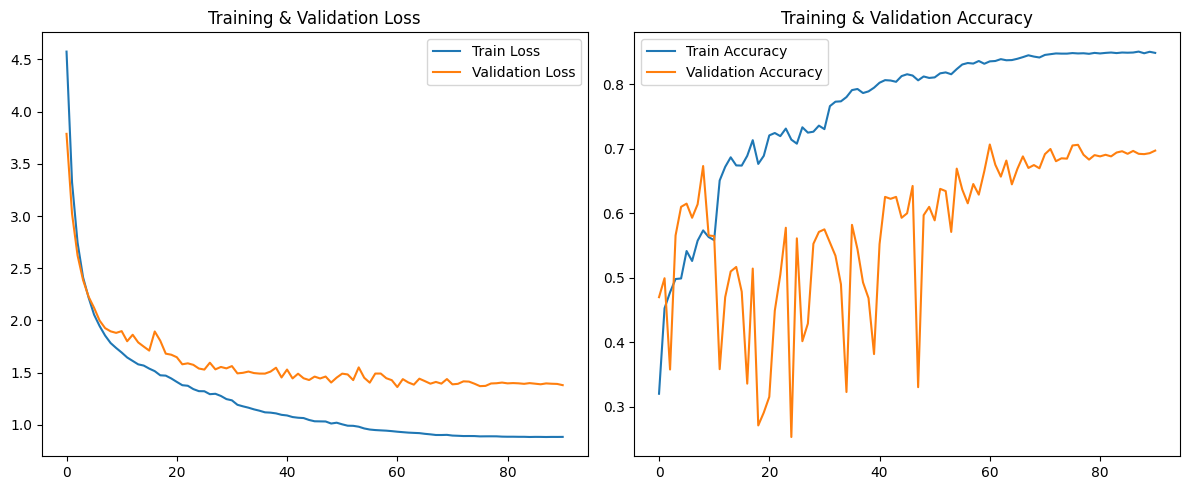

In [9]:
# Evaluate the model on the test set
test_score = model.evaluate(test_generator)
print('Test accuracy:', test_score[1])

# Plot the training and validation accuracy and loss at each epoch
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot Training & Validation Loss
axs[0].plot(history.history['loss'], label='Train Loss')
axs[0].plot(history.history['val_loss'], label='Validation Loss')
axs[0].legend()
axs[0].set_title('Training & Validation Loss')

# Plot Training & Validation Accuracy
axs[1].plot(history.history['acc'], label='Train Accuracy')
axs[1].plot(history.history['val_acc'], label='Validation Accuracy')
axs[1].legend()
axs[1].set_title('Training & Validation Accuracy')

plt.tight_layout()
plt.show()

219/219 [==============================] - 97s 443ms/step


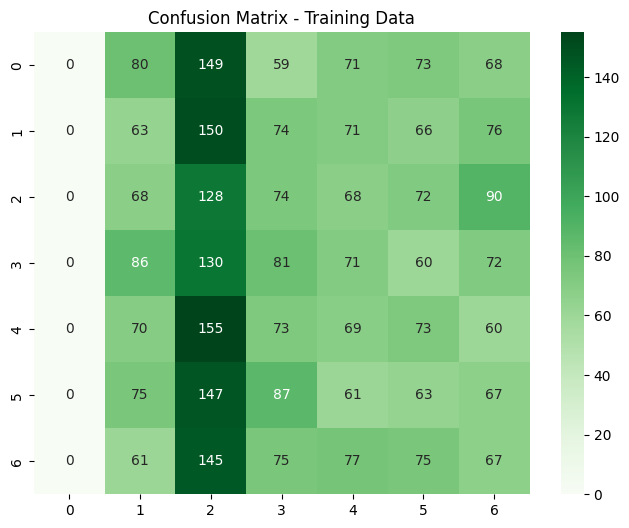

126/126 [==============================] - 34s 271ms/step


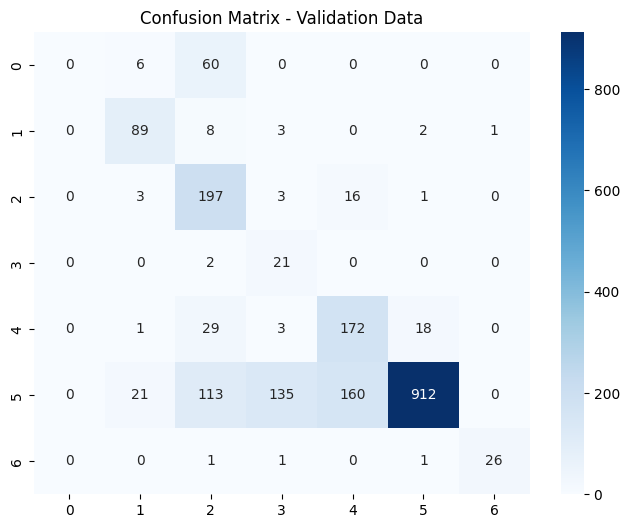

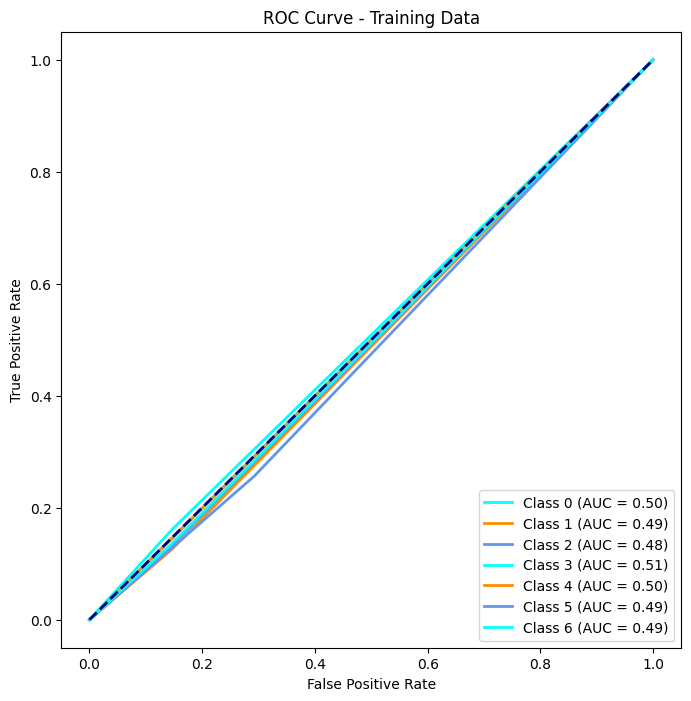

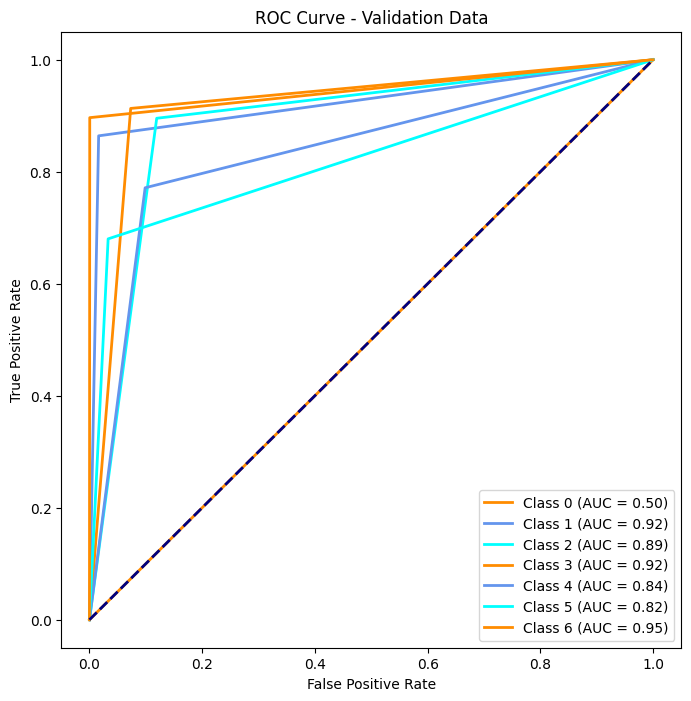

In [10]:
# Confusion matrix for training data
y_train_true = train_generator.classes
y_train_pred = model.predict(train_generator)
y_train_pred_classes = np.argmax(y_train_pred, axis=1)
cm_train = confusion_matrix(y_train_true, y_train_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Greens')
plt.title('Confusion Matrix - Training Data')
plt.show()

# Confusion matrix for validation data
y_val_true = val_generator.classes
y_val_pred = model.predict(val_generator)
y_val_pred_classes = np.argmax(y_val_pred, axis=1)
cm_val = confusion_matrix(y_val_true, y_val_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Validation Data')
plt.show()

# AUC-ROC curve for training data
y_train_true_binary = label_binarize(y_train_true, classes=np.unique(y_train_true))
y_train_pred_binary = label_binarize(y_train_pred_classes, classes=np.unique(y_train_true))

fpr_train = dict()
tpr_train = dict()
roc_auc_train = dict()

for i in range(NUM_CLASSES):
    fpr_train[i], tpr_train[i], _ = roc_curve(y_train_true_binary[:, i], y_train_pred_binary[:, i])
    roc_auc_train[i] = roc_auc_score(y_train_true_binary[:, i], y_train_pred_binary[:, i])

plt.figure(figsize=(8, 8))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])

for i, color in zip(range(NUM_CLASSES), colors):
    plt.plot(fpr_train[i], tpr_train[i], color=color, lw=2, label=f'Class {i} (AUC = {roc_auc_train[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Training Data')
plt.legend(loc='lower right')
plt.show()

# AUC-ROC curve for validation data
y_val_true_binary = label_binarize(y_val_true, classes=np.unique(y_val_true))
y_val_pred_binary = label_binarize(y_val_pred_classes, classes=np.unique(y_val_true))

fpr_val = dict()
tpr_val = dict()
roc_auc_val = dict()

for i in range(NUM_CLASSES):
    fpr_val[i], tpr_val[i], _ = roc_curve(y_val_true_binary[:, i], y_val_pred_binary[:, i])
    roc_auc_val[i] = roc_auc_score(y_val_true_binary[:, i], y_val_pred_binary[:, i])

plt.figure(figsize=(8, 8))
for i, color in zip(range(NUM_CLASSES), colors):
    plt.plot(fpr_val[i], tpr_val[i], color=color, lw=2, label=f'Class {i} (AUC = {roc_auc_val[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Validation Data')
plt.legend(loc='lower right')
plt.show()


In [11]:
x, y  = train_generator.__getitem__(0)

y

array([[0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.]], dtype=float32)

In [12]:
x, y  = test_generator.__getitem__(0)

y

array([[1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [13]:
x, y  = val_generator.__getitem__(0)

y

array([[1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.]], dtype=float32)